# Exercises on Evolutionary Computation

## Exercise 4: Role of selection in GA’ s

4a)

In [20]:
from numpy import copy
import matplotlib.pyplot as plt
from random import randint, random

First, we define a few helper functions for step (a), (b) and (c) of the algorithm. We also make a helper function to make a plot.

In [21]:
# Randomly generate a bit sequence x
def generate_bits(bit_length):
    final_array = []
    for i in range(0, bit_length):
        final_array.append(randint(0, 1))
    return final_array


# Create a copy of x and invert each of its bits with probability invert_prob. Let xnew be the result.
def invert_bits(invert_prob, x):
    xnew = x.copy()
    for i in range(0, len(x)):
        if random() < invert_prob:
            if x[i] == 0:
                xnew[i] = 1
            else:
                xnew[i] = 0
    return xnew


# If xnew is closer to the goal sequence than x then replace x with xnew.
def determine_new_x(fitness_function, x, xnew):
    if fitness_function(xnew) > fitness_function(x):
        return xnew
    else:
        return x
    

# Makes a plot of one run
def make_plot_1_run(x_list, iterations):
    plt.plot(list(range(iterations+1)), x_list)
    plt.title("The best fitness for a (1+1)-GA against the 1500 iterations")
    plt.ylabel("fitness as sum of the bits")
    plt.xlabel("iteration")
    plt.show()

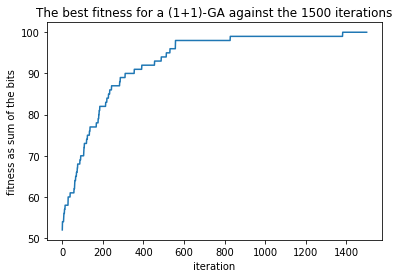

In [22]:
# With bit strings of length 100 and a mutation rate p = 1/100. For a run of 1500
# iterations, we plot the best fitness against the elapsed number of iterations.
def exercise_a(bit_length, iterations):
    invert_prob = 1/bit_length
    x = generate_bits(bit_length)
    f = lambda y: sum(y)
    x_list = [f(x)]
    for i in range(0, iterations):
        xnew = invert_bits(invert_prob, x)
        x = determine_new_x(f, x, xnew)
        x_list.append(f(x))
    make_plot_1_run(x_list, iterations)
    
exercise_a(100, 1500)

4b)

The number of runs that found the optimum for exercise b: 8


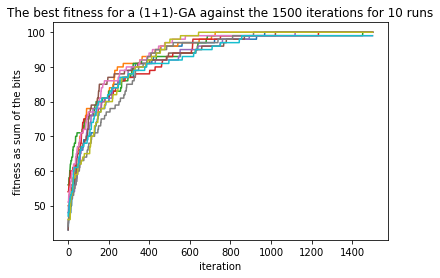

In [23]:
# Makes a plot of ten runs
def make_plot_10_runs(runs_list, iterations, exercise_string):
    for j in runs_list:
        plt.plot(list(range(iterations+1)), j)
    plt.title("The best fitness for a (1+1)-GA against the 1500 iterations for 10 runs")
    plt.ylabel("fitness as sum of the bits")
    plt.xlabel("iteration")
    plt.show()
    

# Performs 10 runs and plots best fitness against elapsed number of iterations of each run in a single figure.
# In the console, we print how many times the algorithm finds the optimum
def exercise_b(bit_length, iterations):
    invert_prob = 1 / bit_length
    runs_list = []
    finds_optimum = 0
    for j in range(0, 10):
        x = generate_bits(bit_length)
        f = lambda y: sum(y)
        x_list = [f(x)]
        for i in range(0, iterations):
            xnew = invert_bits(invert_prob, x)
            x = determine_new_x(f, x, xnew)
            x_list.append(f(x))
        if x_list[-1] == 100:
            finds_optimum += 1
        runs_list.append(x_list)
    print("The number of runs that found the optimum for exercise b: " + str(finds_optimum))
    make_plot_10_runs(runs_list, iterations, 'exercise4b')
    

exercise_b(100, 1500)

4c)

The number of runs that found the optimum for exercise c: 0


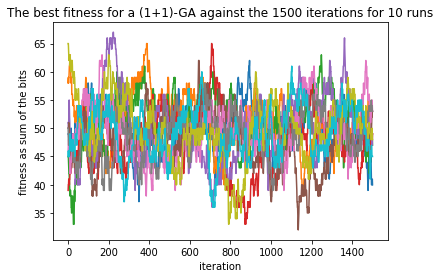

In [24]:
# Performs 10 runs and plots best fitness against elapsed number of iterations of each run in a single figure.
# Using an adapted version of step c (determine new x)
# In the console, we print how many times the algorithm finds the optimum
def exercise_c(bit_length, iterations):
    invert_prob = 1 / bit_length
    runs_list = []
    finds_optimum = 0
    for j in range(0, 10):
        x = generate_bits(bit_length)
        f = lambda y: sum(y)
        x_list = [f(x)]
        for i in range(0, iterations):
            xnew = invert_bits(invert_prob, x)
            x = xnew #NOTE: we do not use determine new x here but immediately return the new x
            x_list.append(f(x))
        if x_list[-1] == 100:
            finds_optimum += 1
        runs_list.append(x_list)
    print("The number of runs that found the optimum for exercise c: " + str(finds_optimum))
    make_plot_10_runs(runs_list, iterations, 'exercise4c')
    
exercise_c(100, 1500)

## Exercise 6: Memetic algorithms vs. simple EAs

In [25]:
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod
from timeit import default_timer as timer
#import yappi

In [26]:
#loading in the given .txt data:
txt_data = np.loadtxt("file-tsp.txt", unpack = False)
txt_data_size = np.shape(txt_data)[0]

**(a)**<br>
Evolutionary algorithm abstract base class:

In [27]:
class ABC_EA(ABC):
    
    @abstractmethod
    def __update_fitness(self):
        '''
            Update the fitness value for the current value of _d_pop.
        '''
        ...

       
    def __init__(self, pop_size, init_pop, cross_prob, mut_prob, rng):
        '''
            Initialize all the necessary values.
            Parameters:
            ----------------------------------
            pop_size: [positive int]
                Population size.
                
            init_pop: [array]
                Initial population.
                
            cross_prob: [float between 0 and 1]
                Probability for crossover to occur.
                
            mut_prob: [float between 0 and 1]
                Probability for mutation to occur.
            
            rng: [random number generator].
        
        '''
        assert 0 <= cross_prob, mut_prob <= 1
              # random number generator:
        self._d_rng = rng
              # population size:
        self._d_pop_size = pop_size
              # population:
        self._d_pop = init_pop
              # population fitness values:
        self._d_fitness = np.zeros(pop_size)
              # crossover probability:
        self._d_cross_prob = cross_prob
              # mutability probability:
        self._d_mut_prob = mut_prob
              # array containing the max fitness each epoch:
        self._d_max_fit = np.array([])
              # array containing the avg. fitness each epoch:
        self._d_avg_fit = np.array([])
              # time taken by optimization:
        self._d_time = 0.
              # updating the fitness:
        self.__update_fitness()
        
    def update_hyps(cross_prob = 'UNDEF', mut_prob = 'UNDEF'):
        '''
            Changes the hyper parameters
            Parameters:
            ----------------------------------
            cross_prob: [float between 0 and 1]
                Probability for crossover to occur.
                
            mut_prob: [float between 0 and 1]
                Probability for mutation to occur.            
        '''
        if cross_prob != 'UNDEF':
            assert 0 <= cross_prob <= 1
            self._d_cross_prob = cross_prob
        if mut_prob != 'UNDEF':
            assert 0 <= mut_prob <= 1
            self._d_mut_prob = mut_prob
            
    
    def __select(self, numb):
        '''
            Select `numb' members from the current population.
            Parameters:
            ----------------------------------
            numb: [positive int]
                Number of members to generate.
        '''
        return self._d_rng.choice(self._d_pop, numb, \
                    p = (self._d_fitness) / np.sum(self._d_fitness))
        
         # to be defined:    
    @abstractmethod
    def __crossover(self, parents, prob):
        '''
            Perform crossover on `parents'.
            Parameters:
            ----------------------------------
            parents: [Array of elements of the same type as _d_pop].
                        
            prob: [float between 0 and 1]
                The crossover probability.
        '''
        ...
    
    
    @abstractmethod
    def __mutate(self, children, prob):
        '''
            Perform a mutation on `children' with probability `prob'.
            Parameters:
            ----------------------------------
            children: [Array of elements of the same type as _d_pop].
            
            prob: [float between 0 and 1]
                The mutation probability.
        '''
        ...

    def __give_additional(self):
        '''
            Print / plot additional information, if the plot option is given in optimize.
        '''
        pass
    
    
    def optimize(self, maxiter, crit = 0, mut_prob = -1, cross_prob = -1,
                 ret = False, plot = False, title = '', time = False, time_limit = 'inf'):
        '''
            Perform the optimization algorithm, until either maxiter epochs have 
            passed, or until the absolute difference of the average fitness 
            between consecutive epochs does not change more than `crit'.
            Parameters:
            ----------------------------------
            maxiter: [positive int]
                Maximum number of iterations to perform.
                
            crit: [non-negative float]
                Stopping criterion.
                
            mut_prob: [float between 0 and 1]
                Mutation probability (for the default -1 we pick standard value).
            
            cross_prob: [float between 0 and 1]
                Crossover probability (for the default -1 we pick standard value).
                
            ret: [boolean]
                If true, we return d_avg_fit, d_max_fit, the individual with the
                highest firness and whether we stopped early.
                
            plot: [boolean]
                Decides whether we plot the progress.
                
            title: [string]
                The title of the plot.
            
            time: [bool]
                If true, prints the total time taken by the optimization.
                
            time_limit: [positive number | 'inf']
                Stops the current run when it starts to exceed time_limit.
        '''
          # start timer:
        start = timer()
        
          # check input:
        assert maxiter >= 0
        
        start_length = np.size(self._d_avg_fit)
        
        temp_avg_fit = np.zeros(maxiter, dtype = int)
        temp_max_fit = np.zeros(maxiter, dtype = int)
        
        stopped_at = maxiter
        crit_achieved = False
        
        if start_length > 2 and \
             np.abs(self._d_avg_fit[-1] - self._d_avg_fit[-2]) < crit:
            crit_achieved = True
            stopped_at = 0
            
          # the algorithm:
        for idx in range(maxiter):
            if crit_achieved or idx > 2 and \
                  np.abs(temp_avg_fit[idx - 1] - temp_avg_fit[idx - 2]) < crit:
                stopped_at = idx
                crit_achieved = True
                break
            
            if time_limit != 'inf' and timer() - start >= time_limit:
                stopped_at = idx
                break
                
            selected = self.__select(self._d_pop_size)
            children = self.__crossover(selected)
            self._d_pop = self.__mutate(children)
            self.__update_fitness()
            temp_max_fit[idx] = np.max(self._d_fitness)
            temp_avg_fit[idx] = np.mean(self._d_fitness)
            
          # update timer (we do not want to count the time plotting takes):
        self._d_time += timer() - start
            
        self._d_avg_fit = np.append(self._d_avg_fit, temp_avg_fit[:stopped_at])
        self._d_max_fit = np.append(self._d_max_fit, temp_max_fit[:stopped_at])
        
          # plotting:
        if plot:
            plt.title(title)
            plt.xlabel('Generation')
            plt.ylabel('Fitness')
            plt.plot(np.arange(start_length + stopped_at, dtype = int), \
                     self._d_avg_fit, label = 'Average fitness')
            plt.plot(np.arange(start_length + stopped_at, dtype = int), \
                     self._d_max_fit, label = 'Best fitness')
            plt.legend()
            plt.show()
            self.__give_additional()
            
        if time:
            print('Time taken:', self._d_time, 'seconds')
            
        best_specimen = self._d_pop[np.argmax(self._d_fitness)]
        
        if ret:    
            return self._d_avg_fit, self._d_max_fit, best_specimen, crit_achieved

Initializing the population for TSP:

In [28]:

  # K-nearest neighbors as initialization, as suggested in [1]:
def KNN_init(data, pop_size,  rng = rnd.default_rng()):
    
    data_size = np.shape(data)[0]
              # indexing the data will be useful later:
    idxed_data = np.concatenate((data, \
                   np.array([np.arange(data_size, dtype = int)]).T), axis = 1)
              # the to be generated population:
    perms = np.zeros(pop_size, dtype = object)
              # generating the population:
    for idx in range(pop_size):
              # choosing a starting position:
        start_pos = rnd.choice(np.arange(data_size))
        perm = [start_pos]
          
              # choosing the nearest neigbor as the next place to visit
              # (recursive function):
        def find_nearest(arr_o_opts, current):
            
              # base case:
            if arr_o_opts.size == 0:
                return []
            
              # find index of nearest neighbor:
            distances = np.linalg.norm(arr_o_opts[:, :2] - current[:2], axis = 1)
            new_idx = np.argmin(distances)
            new = int(arr_o_opts[new_idx, 2])
              
              # updating variables
            current = arr_o_opts[new_idx]
            arr_o_opts = np.delete(arr_o_opts, new_idx, axis = 0)
            
              # recursive call:
            return [new] + find_nearest(arr_o_opts, current)
        
              # creating input and calling function:
        current = idxed_data[start_pos]
        arr_o_opts = np.delete(idxed_data, start_pos, 0)
        perm += find_nearest(arr_o_opts, current)
              # add to population:
        perms[idx] = perm
    return perms

In [29]:
  # Random initialization:
def RND_init(data, pop_size,  rng = rnd.default_rng()):   
    data_size = np.shape(data)[0]
              # the to be generated population:
    perms = np.zeros(pop_size, dtype=object)
              # generating the population:       
    for idx in range(pop_size): 
        perm_size1 = np.shape(data)[0]
        perms[idx] = list(rnd.choice(np.arange(perm_size1), perm_size1, replace = False))
    return perms

Performing a sanity check:

In [30]:
test_pop_size = 10          
test_init = KNN_init(txt_data, test_pop_size)

for idx in range(test_pop_size):
    assert sum(test_init[idx]) == (txt_data_size) * (txt_data_size - 1) / 2

Defining crossover for TSP:

In [31]:
def crossover_on_perms(perm1, perm2, pos1, pos2):
    perm_len = len(perm1)
    assert 0 < pos1 < pos2 < perm_len
    
    def init_new_perm(choice):
        assert choice == 1 or choice == 2
        if choice == 1:
            perm = perm1
            
        elif choice == 2:
            perm = perm2
            
        new_perm =  [-1] * perm_len
        new_perm[pos1 : pos2] = perm[pos1 : pos2]
        return new_perm
    
    new_perm1 = init_new_perm(1)
    new_perm2 = init_new_perm(2)
    
    def fill_in_the_blanks(child_partial, other_parent):
        order = [idx % perm_len for idx in range(pos2, perm_len + pos2)]
        permute_parent = [other_parent[idx] for idx in order]
        up_to = 0
        for idx in order:
            if child_partial[idx] != -1:
                break
            for idy in range(up_to, perm_len):
                if permute_parent[idy] in child_partial[pos1 : pos2]:
                    continue
                else:
                    child_partial[idx] = permute_parent[idy]
                    up_to = idy + 1
                    break
    
    fill_in_the_blanks(new_perm1, perm2)
    fill_in_the_blanks(new_perm2, perm1)
    
    return new_perm1, new_perm2

Sanity check comparing defined function to the example from the slides:

In [32]:
list1 = [3, 4, 7, 2, 1, 6, 4, 8]
list2 = [2, 5, 7, 6, 8, 1, 3, 4]
pos1 = 2
pos2 = 6
children = crossover_on_perms(list1, list2, pos1, pos2)
print('first child =', children[0])
print('second child =', children[1])

first child = [5, 8, 7, 2, 1, 6, 3, 4]
second child = [4, 2, 7, 6, 8, 1, 4, 3]


Defining permutation for TSP:

In [33]:
def mutation_on_perms(perm, pos1, pos2):
    assert  0 <= pos1 < pos2 <= len(perm)
    
    temp_val1 = perm[pos1]
    temp_val2 = perm[pos2]
    
    perm[pos1] = temp_val2
    perm[pos2] = temp_val1
    
    return perm

Sanity check comparing defined function to the example from the slides:

In [34]:
list3 = [5, 8, 7, 2, 1, 6, 3, 4]

print(mutation_on_perms(list3, 2, 5))

[5, 8, 6, 2, 1, 7, 3, 4]


**Pure EA algorithm for TSP:**

In [35]:
class EA_TSP(ABC_EA):
    
    def __tot_distance(self, perm):
        return np.sum(np.linalg.norm(self._d_data[perm[1:]] - self._d_data[perm[:-1]], axis = 1))
    
    
    @staticmethod
    def fitness_tf(x):
        return (1000 / x) ** 4
    
    
    def _ABC_EA__update_fitness(self):
        for idx in range(self._d_pop_size):
            self._d_fitness[idx] = self.fitness_tf(self.__tot_distance(self._d_pop[idx]))

            
    def __init__(self, data, pop_size, init_fun = RND_init, cross_prob = 0.4, mut_prob = 0.1, rng = rnd.default_rng()):
        '''
            Parameters:
            ----------------------------------
            init_fun [function : (data, pop_size, rng) |---> population]
                Should initialize the population.
                
            See base class for other parameters.
        '''
        assert callable(init_fun)
        self._d_data = data
        super().__init__(pop_size, init_fun(data, pop_size, rng), \
                         cross_prob, mut_prob,  rng)
            
            
          # perform a local optimization (none here):
    def __local_opt(self, child):
        return child
        
        
    def _ABC_EA__crossover(self, parents):
        parents_size = np.shape(parents)[0]
        perm_size = len(parents[0])
        children = parents
        to_cross = np.where(self._d_rng.binomial(1, self._d_cross_prob, size = parents_size))[0]
        
        for idx in range(np.size(to_cross)):
            if idx + 1 == np.size(to_cross):
                break
            posits = np.sort(self._d_rng.choice(np.arange(1, perm_size), 2, replace = False))
            children[to_cross[idx]], children[to_cross[idx + 1]] = \
                crossover_on_perms(parents[to_cross[idx]], parents[to_cross[idx + 1]], posits[0], posits[1])
            children[to_cross[idx]] = self.__local_opt(children[to_cross[idx]])
            children[to_cross[idx + 1]] = self.__local_opt(children[to_cross[idx + 1]])
        return children
    
        
    def _ABC_EA__mutate(self, children):
        children_size = np.shape(children)[0]
        child_size = len(children[0])
        to_mutate = np.where(self._d_rng.binomial(1, self._d_mut_prob, children_size))[0]
        if np.size(to_mutate) != 0:
            for idx in to_mutate:
                posits = np.sort(self._d_rng.choice(np.arange(child_size), 2, replace = False))
                children[idx] = mutation_on_perms(children[idx], posits[0], posits[1])
                children[idx] = self.__local_opt(children[idx])
        return children
    
    def _ABC_EA__give_additional(self):
        distances = np.zeros(self._d_pop_size, dtype = object)
        for idx in range(self._d_pop_size):
            distances[idx] = self.__tot_distance(self._d_pop[idx])
        print('Average distance:', np.mean(distances))
        print('Shortest distance:', np.min(distances))
        

Testing the implementation of EA_TSP:

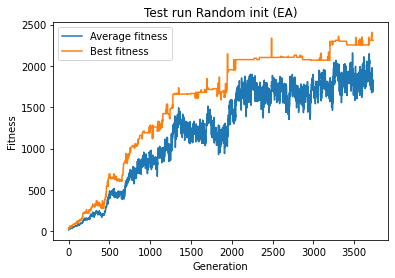

Average distance: 159.47279144832993
Shortest distance: 144.21625718662466
Time taken: 30.005469000000005 seconds
--------------------------------------------------


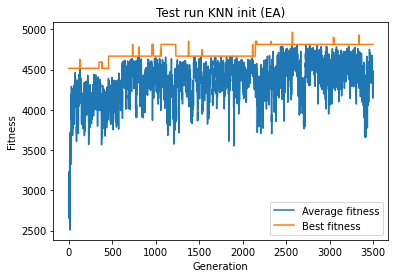

Average distance: 124.06279626650418
Shortest distance: 120.05181156564878
Time taken: 30.00099180000001 seconds

best rout: [47, 48, 49, 42, 41, 38, 40, 44, 43, 46, 45, 35, 31, 28, 29, 25, 22, 18, 15, 16, 13, 12, 7, 19, 27, 39, 21, 24, 17, 20, 23, 30, 33, 32, 36, 37, 34, 26, 14, 8, 6, 4, 0, 3, 1, 9, 10, 11, 5, 2]


In [36]:
ev_alg = EA_TSP(txt_data, 200,  mut_prob = 0.01, cross_prob = 0.2)
ev_alg.optimize(10000, title = 'Test run Random init (EA)', plot = True, time = True, time_limit = 30)

print('--------------------------------------------------')

ev_alg1 = EA_TSP(txt_data, 200, KNN_init, mut_prob = 0.01, cross_prob = 0.2)
arr_avg, arr_max, best, _ = ev_alg1.optimize(10000, title = 'Test run KNN init (EA)', \
                                             plot = True, ret = True, time = True, time_limit = 30)

print('\nbest rout:', best)

**Defining MA for TSP:**

In [37]:
class MA_TSP(EA_TSP):

    def __init__(self, data, pop_size, init_fun = RND_init, cross_prob = 0.4, \
                 mut_prob = 0.1, opt_it = 'inf', rng = rnd.default_rng()):
        '''
            Parameters:
            ----------------------------------
            opt_int [positive integer | 'inf']:
                If `opt_int' is 'inf', then 2-opt will run untill no improvements
                are made. If `opt_int' is an integer, we will apply 2-opt, `opt_int'
                at most number of times every time we apply the local optimization.
                
            See base class for other parameters.
        '''
        super().__init__(data, pop_size, init_fun, cross_prob, mut_prob, rng)
        self._d_opt_it = opt_it

    
    def _EA_TSP__local_opt(self, child):
        opt_it = self._d_opt_it
        current_dist = self._EA_TSP__tot_distance(child)
        current_child = child
          # apply 2-opt until no improvements are made, or until opt_it is zero:
        while True:
            if opt_it == 0:
                break
            
            change = False
            
            for idx in range(len(self._d_data[0])):
                for idy in range(idx + 1, len(self._d_data[0])):
                    child = self.__two_opt_step(child, idx, idy)
            
                    new_dist = self._EA_TSP__tot_distance(child)  
                    if new_dist > current_dist:
                        change = True
                        current_dist = new_dist
                        current_child = child

            if opt_it != 'inf':
                opt_it -= 1
            if not change:
                break
        return current_child
    
    
    def update_hyps(self, cross_prob = 'UNDEF', mut_prob = 'UNDEF', opt_it = 'UNDEF'):
        super().update_hyps(cross_prob = 'UNDEF', mut_prob = 'UNDEF')
        if opt_it != 'UNDEF':
            self._d_opt_it = opt_it
            
        
    def __two_opt_step(self, perm, pos1, pos2):
        assert 0 <= pos1 < pos2 <= len(perm)
          # reversing has no effect:
        if pos1 == 0 and pos2 == len(perm):
            return perm
        
        current_dist = self._EA_TSP__tot_distance(perm)
          # exploting that the current distance is similar to the new distance (in its path)
        alt_dist = current_dist + np.linalg.norm(self._d_data[perm[pos1 - 1]] - self._d_data[perm[pos1]]) \
                                + np.linalg.norm(self._d_data[perm[pos2 - 1]] - self._d_data[perm[pos2]]) \
                                - np.linalg.norm(self._d_data[perm[pos1 - 1]] - self._d_data[perm[pos2 - 1]]) \
                                - np.linalg.norm(self._d_data[perm[pos1]] - self._d_data[perm[pos2]])

        if alt_dist < current_dist:
            return perm[: pos1] + perm[pos1 : pos2][:: -1] + perm[pos2 :]
        else:
            return perm


Testing the implementation of MA_TSP:

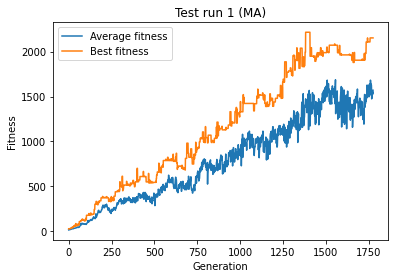

Average distance: 162.87610625062422
Shortest distance: 146.8145836292899
Time taken: 30.00391829999998 seconds
--------------------------------------------------


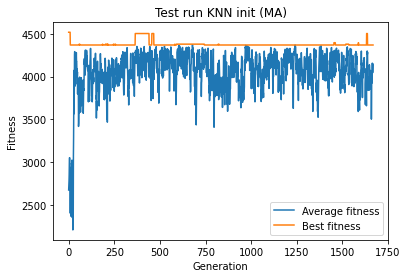

Average distance: 125.94579176728872
Shortest distance: 123.00237391331014
Time taken: 30.007728200000003 seconds

best rout: [1, 3, 4, 6, 0, 8, 14, 9, 10, 11, 5, 2, 15, 18, 22, 25, 24, 17, 20, 23, 30, 33, 32, 38, 40, 44, 41, 42, 36, 37, 34, 26, 47, 48, 49, 43, 46, 45, 35, 31, 28, 29, 21, 16, 13, 12, 7, 19, 27, 39]


In [38]:
mn_alg = MA_TSP(txt_data, 200,  mut_prob = 0.01, cross_prob = 0.2)
mn_alg.optimize(10000, title = 'Test run 1 (MA)', plot = True, time = True, time_limit = 30)

print('--------------------------------------------------')

mn_alg1 = MA_TSP(txt_data, 200, KNN_init, mut_prob = 0.01, cross_prob = 0.2)
arr_avg, arr_max, best, _ = mn_alg1.optimize(10000, title = 'Test run KNN init (MA)', \
                                             plot = True, ret = True, time = True, time_limit = 30)

print('\nbest rout:', best)

**TEMP:** Below we do a bit of profiling, I think you need to restart the kernel every time.

In [39]:
yappi.set_clock_type("cpu")
yappi.start()

ev_alg1 = MA_TSP(txt_data, 1000, KNN_init, mut_prob = 0.01, cross_prob = 0.2)
ev_alg1.optimize(1000, time_limit = 120)

stats = yappi.get_func_stats().sort('ttot').strip_dirs()
stats.print_all(columns={0: ('name', 45), 1: ('ncall', 10), 2: ('tsub', 8), 3: ('ttot', 8), 4: ('tavg', 8)})

NameError: name 'yappi' is not defined

**(b)**

In [ ]:

  # create comparative plots:
def create_data(numb_iter, title, data, maxiter, pop_size, init_fun = RND_init, \
                cross_prob = 0.2, mut_prob = 0.05, time_limit = 'inf'):
    
    fig, axs = plt.subplots(2, 2, figsize=(10, 8), constrained_layout = True)
      # obtain results:
    def perform_runs(method_construct):
        method_avg = np.zeros(numb_iter, dtype = object)
        method_best = np.zeros(numb_iter, dtype = object)

        for idx in range(numb_iter):
            ev_alg = method_construct(data, pop_size, init_fun = init_fun, mut_prob = mut_prob, \
                                      cross_prob = cross_prob)
            avg, best, _, _ = ev_alg.optimize(maxiter, ret = True, time_limit = time_limit)

            method_avg[idx]  = avg
            method_best[idx] = best
            
        return method_avg, method_best
    
    EA_avg, EA_best = perform_runs(EA_TSP)
    MA_avg, MA_best = perform_runs(MA_TSP)
    
      # make subplot:
    def make_plot(idx, idy, runs, header):
        for run in runs:
            axs[idx, idy].set_title(header + title)
            axs[idx, idy].plot(np.arange(np.size(run)),  1000 / (run) ** (1/4))
            axs[idx, idy].set_xlabel("Generations")
            axs[idx, idy].set_ylabel("Distance")
    
    make_plot(0, 0, EA_avg, 'EA avg: ')
    make_plot(1, 0, EA_best, 'EA best: ')
    make_plot(0, 1, MA_avg, 'MA avg: ')
    make_plot(1, 1, MA_best, 'MA best: ')

    
    

In [ ]:
# create_data(10, 'txt data', txt_data, 1500, 200)

**(c)**

**(d)**

**(e)**

**(f)**

## Exercise 8: Genetic Programming behaviour

We will use the framework DEAP for this exercise (https://deap.readthedocs.io/en/master/). First, we will need some imports. For any package that is not installed yet, you can use the first two lines.

In [43]:
#run these first two lines for any package that is not yet installed
# import sys
# !{sys.executable} -m pip install deap
import operator
import math
import random
import string  

import numpy

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

import matplotlib.pyplot as plt

Next, we will followed the example code for symbolic regression explained in the docs (https://deap.readthedocs.io/en/master/examples/gp_symbreg.html).

In [104]:
#define a protected division operator
def protectedDiv(left, right):
    try:
        return left / right
    except ZeroDivisionError:
        return 1

# define the function set using primitives    
pset = gp.PrimitiveSet("MAIN", 1)
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(protectedDiv, 2)
pset.addPrimitive(math.cos, 1)
pset.addPrimitive(math.sin, 1)
# pset.addPrimitive(math.log, 1)
# pset.addPrimitive(math.exp, 1)

# define the terminal set, which is only the variable x
pset.renameArguments(ARG0='x')

# we want to maximize the fitness, the exact fitness function will be defined later on
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
# the individual is a tree with nodes from the primitive set and leafs from the terminal set
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMax)

# registering parameters specific to the evolution process using the toolbox
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
# create the population by repeating the individual initialization
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
# compile will be used to transform the tree expression in a callable function
toolbox.register("compile", gp.compile, pset=pset)

# the actual fitness function, which should be: - sum of absolute errors.
def evalSymbReg(individual, points):
    func = toolbox.compile(expr=individual)
    sum_abs_err = 0
    # points[0] is the input and points[1] is the output
    for i in range(0, len(points[0])):
        sum_abs_err += abs(func(points[0][i]) - points[1][i])
    return -sum_abs_err,

# define the data as stated in the exercise
inp = np.arange(-1, 1.1, 0.1).tolist()
outp = [0.0000, -0.1629, -0.2624, -0.3129, -0.3264, -0.3125, -0.2784, -0.2289, -0.1664, -0.0909, 0.0, 0.1111, 0.2496, 0.4251, 0.6496, 0.9375, 1.3056, 1.7731, 2.3616, 3.0951, 4.000]

# adding the defined fitness function to the toolbox
toolbox.register("evaluate", evalSymbReg, points=[inp,outp])
# use tournament selection as suggested in the slides
toolbox.register("select", tools.selTournament, tournsize=3)
# one point crossover with uniform probability over all the nodes
toolbox.register("mate", gp.cxOnePoint)
# a uniform probability mutation which may append a new full sub-tree to a node
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

# decorate mate and mutate method to limit the height of generated individuals, to avoid bloating
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

Now, we can write the main part of the GA. Note that usually you would run `pop, log = algorithms.eaSimple(pop, toolbox, 0.7, 0, 1, stats=mstats, halloffame=hof, verbose=True)` for the number of generations. However, we need to store the best individual per generation because we need to plot the size of the best individual for exercise 8b. This also means we cannot easily use the logbook. We chose to store the information that we need in the lists instead of trying to extend the logbook after every generation.

In [105]:
random.seed(318)
ngen = 50
pop = toolbox.population(n=1000)
# hall of fame is specific structure which contains the n best individuals
# we only need 1 because we want to make plots using the best individual
hof = tools.HallOfFame(1)

# statistics to compute the mean, standard deviation, minimum, and maximum of both the individuals fitness and size
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", numpy.mean)
mstats.register("std", numpy.std)
mstats.register("min", numpy.min)
mstats.register("max", numpy.max)

# the actual algorithm
best_ind = []
fit_max = []
size_avgs = []
size_max = []
size_min = []
for i in range(ngen):
    # runs the algorithm for 1 generation and updates the population
    pop, log = algorithms.eaSimple(pop, toolbox, 0.7, 0, 1, stats=mstats, halloffame=hof, verbose=True)
    best_ind.append(len(tools.selBest(pop, k=1)[0]))
    fit_max.append(log.chapters["fitness"].select("max")[1])
    size_avgs.append(log.chapters["size"].select("avg")[1])
    size_max.append(log.chapters["size"].select("max")[1])
    size_min.append(log.chapters["size"].select("min")[1])

   	      	                              fitness                              	                      size                     
   	      	-------------------------------------------------------------------	-----------------------------------------------
gen	nevals	avg         	gen	max  	min         	nevals	std        	avg  	gen	max	min	nevals	std    
0  	1000  	-1.21694e+29	0  	-6.05	-2.02824e+31	1000  	1.56635e+30	3.949	0  	7  	2  	1000  	1.66024
1  	728   	-4.5036e+12 	1  	-6.05	-4.5036e+15 	728   	1.42345e+14	3.68 	1  	9  	2  	728   	1.59047
   	      	                              fitness                              	                      size                     
   	      	-------------------------------------------------------------------	-----------------------------------------------
gen	nevals	avg        	gen	max  	min        	nevals	std        	avg 	gen	max	min	nevals	std    
0  	0     	-4.5036e+12	0  	-6.05	-4.5036e+15	0     	1.42345e+14	3.68	0  	9  	2  	0     	1.59047
1  

0  	0     	-4.5036e+12	0  	-1.79717e-14	-4.5036e+15	0     	1.42345e+14	15.621	0  	39 	3  	0     	6.13216
1  	672   	-3.9499    	1  	-1.79717e-14	-27.7086   	672   	3.85742    	15.864	1  	47 	3  	672   	5.71695
   	      	                            fitness                            	                      size                     
   	      	---------------------------------------------------------------	-----------------------------------------------
gen	nevals	avg    	gen	max         	min     	nevals	std    	avg   	gen	max	min	nevals	std    
0  	0     	-3.9499	0  	-1.79717e-14	-27.7086	0     	3.85742	15.864	0  	47 	3  	0     	5.71695
1  	760   	-4.5036e+12	1  	-1.79717e-14	-4.5036e+15	760   	1.42345e+14	15.791	1  	41 	3  	760   	5.876  
   	      	                                  fitness                                  	                     size                    
   	      	---------------------------------------------------------------------------	-------------------------------

   	      	                            fitness                            	                     size                     
   	      	---------------------------------------------------------------	----------------------------------------------
gen	nevals	avg    	gen	max        	min     	nevals	std    	avg  	gen	max	min	nevals	std   
0  	0     	-2.9625	0  	-1.7944e-14	-26.6468	0     	4.10724	22.35	0  	53 	7  	0     	5.7839
1  	728   	-2.88198	1  	-1.7944e-14	-21.1977	728   	3.7548 	22.736	1  	47 	7  	728   	6.39455
   	      	                               fitness                                	                      size                     
   	      	----------------------------------------------------------------------	-----------------------------------------------
gen	nevals	avg     	gen	max        	min     	nevals	std   	avg   	gen	max	min	nevals	std    
0  	0     	-2.88198	0  	-1.7944e-14	-21.1977	0     	3.7548	22.736	0  	47 	7  	0     	6.39455
1  	700   	-2.85951	1  	-1.7944e-1

1  	680   	-9.0072e+12	1  	-1.77219e-14	-4.5036e+15	680   	2.01206e+14	26.298	1  	65 	5  	680   	8.34405
   	      	                                  fitness                                  	                      size                     
   	      	---------------------------------------------------------------------------	-----------------------------------------------
gen	nevals	avg        	gen	max         	min        	nevals	std        	avg   	gen	max	min	nevals	std    
0  	0     	-9.0072e+12	0  	-1.77219e-14	-4.5036e+15	0     	2.01206e+14	26.298	0  	65 	5  	0     	8.34405
1  	676   	-4.64434e+12	1  	-1.77219e-14	-4.5036e+15	676   	1.4241e+14 	27.366	1  	71 	9  	676   	8.90831
   	      	                                 fitness                                  	                      size                     
   	      	--------------------------------------------------------------------------	-----------------------------------------------
gen	nevals	avg         	gen	max         	

In [106]:
# check that the found function fits nicely
bests = tools.selBest(pop, k=1)
func = toolbox.compile(expr=bests[0])
print("Best fitting function: " + str(bests[0]) + "\n")

print("Output found function" + "\t\t" + "Actual output")
for x in range(0,len(inp)):
    print("{:.4f}".format(func(inp[x])) + "\t\t\t\t" + str(outp[x]))

Best fitting function: add(mul(x, mul(protectedDiv(add(mul(x, x), protectedDiv(mul(x, x), x)), protectedDiv(mul(x, add(mul(x, x), x)), x)), mul(protectedDiv(add(mul(x, x), protectedDiv(mul(x, x), x)), protectedDiv(mul(x, x), x)), mul(x, x)))), add(mul(x, x), x))

Output found function		Actual output
0.0000				0.0
-0.1629				-0.1629
-0.2624				-0.2624
-0.3129				-0.3129
-0.3264				-0.3264
-0.3125				-0.3125
-0.2784				-0.2784
-0.2289				-0.2289
-0.1664				-0.1664
-0.0909				-0.0909
-0.0000				0.0
0.1111				0.1111
0.2496				0.2496
0.4251				0.4251
0.6496				0.6496
0.9375				0.9375
1.3056				1.3056
1.7731				1.7731
2.3616				2.3616
3.0951				3.0951
4.0000				4.0


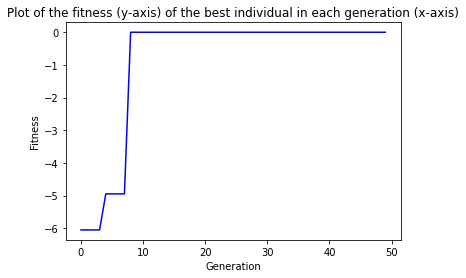

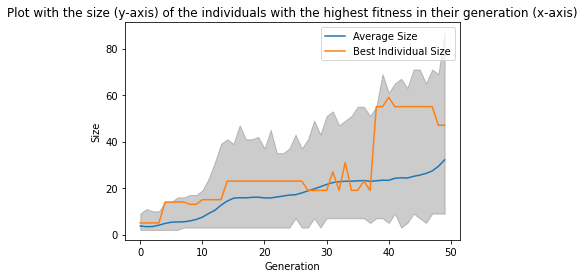

In [107]:
gen = np.arange(0, 50).tolist()

#plot for exercise 8a
plt.plot(gen, fit_max, "b-", label="Minimum Fitness")
plt.title("Plot of the fitness (y-axis) of the best individual in each generation (x-axis)")
plt.ylabel("Fitness")
plt.xlabel("Generation")
plt.show()

#plot for exercise 8b
plt.plot(gen, size_avgs, label="Average Size")
plt.plot(gen, best_ind, label="Best Individual Size")
plt.fill_between(gen, size_min, size_max,
                 facecolor="orange", # The fill color
                 color='black',       # The outline color
                 alpha=0.2)          # Transparency of the fill
plt.title("Plot with the size (y-axis) of the individuals with the highest fitness in their generation (x-axis)")
plt.ylabel("Size")
plt.xlabel("Generation")
plt.legend()
plt.show()

Note that we commented out the exp and log functions. If we add them to the function set, we get different (worse) results. We thought this was interesting and although the exercise only wants the exercise below, we wanted to include the better fitting function without exp and log.

In [108]:
#define a protected division operator
def protectedDiv(left, right):
    try:
        return left / right
    except ZeroDivisionError:
        return 1
    
#define a protected log operator
def protectedLog(x):
    try:
        return math.log(x)
    except ValueError:
        return 1
    
#define a protected log operator
def protectedExp(x):
    try:
        return math.exp(x)
    except (ValueError, OverflowError):
        return 1

# define the function set using primitives    
pset = gp.PrimitiveSet("MAIN", 1)
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(protectedDiv, 2)
pset.addPrimitive(math.cos, 1)
pset.addPrimitive(math.sin, 1)
pset.addPrimitive(protectedLog, 1)
pset.addPrimitive(protectedExp, 1)

# define the terminal set, which is only the variable x
pset.renameArguments(ARG0='x')

# we want to maximize the fitness, the exact fitness function will be defined later on
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
# the individual is a tree with nodes from the primitive set and leafs from the terminal set
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMax)

# registering parameters specific to the evolution process using the toolbox
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
# create the population by repeating the individual initialization
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
# compile will be used to transform the tree expression in a callable function
toolbox.register("compile", gp.compile, pset=pset)

# the actual fitness function, which should be: - sum of absolute errors.
def evalSymbReg(individual, points):
    func = toolbox.compile(expr=individual)
    sum_abs_err = 0
    # points[0] is the input and points[1] is the output
    for i in range(0, len(points[0])):
        sum_abs_err += abs(func(points[0][i]) - points[1][i])
    return -sum_abs_err,

# define the data as stated in the exercise
inp = np.arange(-1, 1.1, 0.1).tolist()
outp = [0.0000, -0.1629, -0.2624, -0.3129, -0.3264, -0.3125, -0.2784, -0.2289, -0.1664, -0.0909, 0.0, 0.1111, 0.2496, 0.4251, 0.6496, 0.9375, 1.3056, 1.7731, 2.3616, 3.0951, 4.000]

# adding the defined fitness function to the toolbox
toolbox.register("evaluate", evalSymbReg, points=[inp,outp])
# use tournament selection as suggested in the slides
toolbox.register("select", tools.selTournament, tournsize=3)
# one point crossover with uniform probability over all the nodes
toolbox.register("mate", gp.cxOnePoint)
# a uniform probability mutation which may append a new full sub-tree to a node
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

# decorate mate and mutate method to limit the height of generated individuals, to avoid bloating
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

In [109]:
random.seed(318)
ngen = 50
pop = toolbox.population(n=1000)
# hall of fame is specific structure which contains the n best individuals
# we only need 1 because we want to make plots using the best individual
hof = tools.HallOfFame(1)

# statistics to compute the mean, standard deviation, minimum, and maximum of both the individuals fitness and size
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", numpy.mean)
mstats.register("std", numpy.std)
mstats.register("min", numpy.min)
mstats.register("max", numpy.max)

# the actual algorithm
best_ind = []
fit_max = []
size_avgs = []
size_max = []
size_min = []
for i in range(ngen):
    # runs the algorithm for 1 generation and updates the population
    pop, log = algorithms.eaSimple(pop, toolbox, 0.7, 0, 1, stats=mstats, halloffame=hof, verbose=True)
    best_ind.append(len(tools.selBest(pop, k=1)[0]))
    fit_max.append(log.chapters["fitness"].select("max")[1])
    size_avgs.append(log.chapters["size"].select("avg")[1])
    size_max.append(log.chapters["size"].select("max")[1])
    size_min.append(log.chapters["size"].select("min")[1])

   	      	                                 fitness                                 	                      size                     
   	      	-------------------------------------------------------------------------	-----------------------------------------------
gen	nevals	avg         	gen	max     	min         	nevals	std      	avg  	gen	max	min	nevals	std    
0  	1000  	-1.41977e+29	0  	-4.24698	-2.02824e+31	1000  	1.691e+30	3.578	0  	7  	2  	1000  	1.52772
1  	696   	-6.7554e+12 	1  	-4.24698	-4.5036e+15 	696   	1.59083e+14	3.436	1  	8  	2  	696   	1.56649
   	      	                                  fitness                                  	                      size                     
   	      	---------------------------------------------------------------------------	-----------------------------------------------
gen	nevals	avg        	gen	max     	min        	nevals	std        	avg  	gen	max	min	nevals	std    
0  	0     	-6.7554e+12	0  	-4.24698	-4.5036e+15	0     	1.59083

1  	696   	-7.53259	1  	-1.60672	-59.7315	696   	7.05506	8.724	1  	23 	3  	696   	3.35109
   	      	                                fitness                                	                      size                     
   	      	-----------------------------------------------------------------------	-----------------------------------------------
gen	nevals	avg     	gen	max     	min     	nevals	std    	avg  	gen	max	min	nevals	std    
0  	0     	-7.53259	0  	-1.60672	-59.7315	0     	7.05506	8.724	0  	23 	3  	0     	3.35109
1  	660   	-6.81373	1  	-0.880766	-63.0797	660   	6.94808	8.944	1  	22 	3  	660   	3.34767
   	      	                                fitness                                	                      size                     
   	      	-----------------------------------------------------------------------	-----------------------------------------------
gen	nevals	avg     	gen	max      	min     	nevals	std    	avg  	gen	max	min	nevals	std    
0  	0     	-6.81373	0  	

1  	684   	-3.52048	1  	-0.341237	-69.4667	684   	4.96537	15.847	1  	38 	4  	684   	4.88504
   	      	                                fitness                                	                      size                     
   	      	-----------------------------------------------------------------------	-----------------------------------------------
gen	nevals	avg     	gen	max      	min     	nevals	std    	avg   	gen	max	min	nevals	std    
0  	0     	-3.52048	0  	-0.341237	-69.4667	0     	4.96537	15.847	0  	38 	4  	0     	4.88504
1  	686   	-3.53763	1  	-0.341237	-47.0774	686   	4.78111	15.963	1  	39 	4  	686   	5.21379
   	      	                                fitness                                	                      size                     
   	      	-----------------------------------------------------------------------	-----------------------------------------------
gen	nevals	avg     	gen	max      	min     	nevals	std    	avg   	gen	max	min	nevals	std    
0  	0     	-3.53

In [110]:
# check that the found function fits nicely
bests = tools.selBest(pop, k=1)
func = toolbox.compile(expr=bests[0])
print("Best fitting function: " + str(bests[0]) + "\n")

print("Output found function" + "\t\t" + "Actual output")
for x in range(0,len(inp)):
    print("{:.4f}".format(func(inp[x])) + "\t\t\t\t" + str(outp[x]))

Best fitting function: add(add(mul(mul(x, sin(sin(sin(x)))), mul(x, x)), x), mul(protectedExp(x), mul(sin(x), x)))

Output found function		Actual output
-0.0120				0.0
-0.1406				-0.1629
-0.2293				-0.2624
-0.2822				-0.3129
-0.3039				-0.3264
-0.2990				-0.3125
-0.2719				-0.2784
-0.2266				-0.2289
-0.1659				-0.1664
-0.0909				-0.0909
-0.0000				0.0
0.1111				0.1111
0.2501				0.2496
0.4274				0.4251
0.6561				0.6496
0.9509				0.9375
1.3275				1.3056
1.8019				1.7731
2.3901				2.3616
3.1068				3.0951
3.9658				4.0


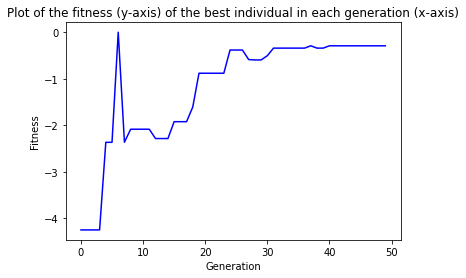

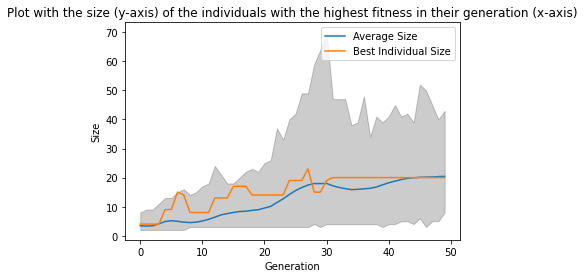

In [111]:
gen = np.arange(0, 50).tolist()

#plot for exercise 8a
plt.plot(gen, fit_max, "b-", label="Minimum Fitness")
plt.title("Plot of the fitness (y-axis) of the best individual in each generation (x-axis)")
plt.ylabel("Fitness")
plt.xlabel("Generation")
plt.show()

#plot for exercise 8b
plt.plot(gen, size_avgs, label="Average Size")
plt.plot(gen, best_ind, label="Best Individual Size")
plt.fill_between(gen, size_min, size_max,
                 facecolor="orange", # The fill color
                 color='black',       # The outline color
                 alpha=0.2)          # Transparency of the fill
plt.title("Plot with the size (y-axis) of the individuals with the highest fitness in their generation (x-axis)")
plt.ylabel("Size")
plt.xlabel("Generation")
plt.legend()
plt.show()

## References:

[1] Automatic Combination of Operators in a Genetic Algorithm to Solve the Traveling Salesman Problem